### Packages and paths

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from ts2dte import ts2dte

### Define relevant functions

### Set up the files and grid, read files

In [2]:
# set the grid
nx=20
ny=16
nz=23

pt = np.array([[8,11,4],
               [10,9,0],
               [12,7,0],
               [18,1,0]])

In [3]:
# read in the files - she did .data but I guess I will do .meta
dirrun = "/scratch2/atnguyen/labsea/layers/run_c68r_layers_03Jun2023_noOL_10d/"
dirIn = dirrun + "diags/BUDG/"
dirGrid = "/scratch2/atnguyen/labsea/GRID_r8/"

In [4]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# make an example string for parsemeta
t_day = str(int(dt/60/60) * 2)
tsstr = t_day.zfill(10)
print(tsstr)

0000000048


In [5]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [6]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(23,) (23, 16, 20)


In [7]:
# fig = plt.figure()
# ax = plt.subplot(2,2,1)
# pcm = ax.pcolormesh(drf3d[0])
# fig.colorbar(pcm, ax=ax)

# ax = plt.subplot(2,2,2)
# pcm = ax.pcolormesh(drf3d[10])
# fig.colorbar(pcm, ax=ax)
# print(mygrid['DRF'][10])

# ax = plt.subplot(2,2,3)
# pcm = ax.pcolormesh(DD3d[0])
# fig.colorbar(pcm, ax=ax)

# ax = plt.subplot(2,2,4)
# pcm = ax.pcolormesh(DD3d[10]-DD3d[0])
# fig.colorbar(pcm, ax=ax)

### Ocean and Ice tendency

In [8]:
# ocean and ice
AB_gT=0

In [9]:
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr + ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[0])
PHIBOT,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[1])
SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[2])
SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),np.nan,returnmeta=True,rec=recs[3])

ETAN =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt
PHIBOT = (PHIBOT[1, :, :] - PHIBOT[0, :, :]) / dt
SIheff =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
SIhsnow = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

In [10]:
# ocean
t1i = 0
t2i = 1
t1 = its[t1i]
t2 = its[t2i]     # we can still do this because it is from the same file, even if only reading one field

In [11]:
# 3D, with rStar:
# mk3D_mod function should be called here but I might be doing it wrong
tmptend = np.zeros((nz, ny, nx))
if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
    tmptend[0,:, :] = ETAN * myparms['rhoconst'] * RAC
    if myparms['useRFWF'] == 0:
        tmptend[0, :, :] = np.zeros((ny, nx))
else:
    if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
        tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC
        tmp2 = tmp1/mk3D_mod(DD,tmp1)
    else:
        tmp2 = drf3d / mk3D_mod(DD, tmp1)
        
    tmptend = tmp2 * mk3D_mod(ETAN, tmp2) * myparms['rhoconst'] * mk3D_mod(RAC, hfC)

In [12]:
# this is wrong rewrite
# An has written nansum(tmptend, axis=3) but this is her z axis; I think we want axis = 0
budgO = {'fluxes': {'tend': tmptend}}
budgO['tend'] = np.nansum(tmptend,axis=0)
budgI = {'tend': (SIheff * myparms['rhoi'] + SIhsnow * myparms['rhosn']) * RAC}

In [13]:
# budgI = {'tend': (SIheff * myparms['rhoi'] + SIhsnow * myparms['rhosn']) * RAC}
budgOI = {}
budgOI['tend'] = budgO['tend'] + budgI['tend']

In [14]:
# clear memory
del ETAN, PHIBOT, SIheff, SIhsnow, tmptend

### Vertical convergence

In [15]:
# rewrite with only reading in these lines, be sure to compare
meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceFWflx,its,meta = rdmds(dirIn + "budg2d_zflux_set1", t2,returnmeta=True,rec = recs[0])
SIatmFW,its,meta = rdmds(dirIn + "budg2d_zflux_set1", t2,returnmeta=True,rec = recs[1])

# read WVELMASS
meta_budg3d_zflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr + '.meta')
fldlist = np.array(meta_budg3d_zflux_set2['fldList'])
varnames = np.array(['WVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
WVELMASS,its,meta = rdmds(dirIn + "budg3d_zflux_set2", t2,returnmeta=True,rec = recs[0])

In [16]:
# Perform calculations
budgO["zconv"] = oceFWflx
budgI["zconv"] = SIatmFW - oceFWflx

if not myparms["useRFWF"]:
    budgO["zconv"] = 0 * budgO["zconv"]

trWtop = -WVELMASS * myparms["rhoconst"]
print(trWtop.shape)

# indexing seems fishy here - rewrite
if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO["fluxes"]["trWtop"] = trWtop * RAC3
budgO["fluxes"]["trWbot"] = trWbot * RAC3
budgO["fluxes"]["zconv"] = budgO["fluxes"]["trWtop"] - budgO["fluxes"]["trWbot"]

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO["zconv"] += np.sum(trWtop - trWbot, axis=0)

budgI["fluxes"] = {}
budgI["fluxes"]["trWtop"] = -RAC * (budgI["zconv"] + budgO["zconv"])
budgI["fluxes"]["trWbot"] = -RAC * budgO["zconv"]

budgO["zconv"] = RAC * budgO["zconv"]
budgI["zconv"] = RAC * budgI["zconv"]
budgOI["zconv"] = budgO["zconv"] + budgI["zconv"]

(23, 16, 20)


In [17]:
# clear memory
del oceFWflx, SIatmFW, WVELMASS

### Horizontal convergence

In [18]:
# read U and V mass
meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", t2,returnmeta=True,rec = recs[0])
VVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", t2,returnmeta=True,rec = recs[1])

# read advective
meta_budg2d_hflux_set1= parsemeta(dirIn + "budg2d_hflux_set1" + '.' + tsstr + '.meta')
fldlist = np.array(meta_budg2d_hflux_set1['fldList'])
varnames = np.array(['ADVxHEFF','ADVyHEFF','ADVxSNOW','ADVySNOW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", t2,returnmeta=True,rec = recs[0])
ADVyHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", t2,returnmeta=True,rec = recs[1])
ADVxSNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", t2,returnmeta=True,rec = recs[2])
ADVySNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", t2,returnmeta=True,rec = recs[3])

In [19]:
# THERE IS NO DFXEHEFF OR DFYEHEFF! This has not been handled in this notebook
# Calculations for ocean
tmpUo = myparms['rhoconst'] * dyg3d * drf3d * UVELMASS
tmpVo = myparms['rhoconst'] * dxg3d * drf3d * VVELMASS

tmpUi = myparms['rhoi'] * ADVxHEFF + myparms['rhosn'] * ADVxSNOW
tmpVi = myparms['rhoi'] * ADVyHEFF + myparms['rhosn'] * ADVySNOW

In [20]:
# budgO = {}
#budgO['fluxes'] = {}
budgO['fluxes']['hconv'] = calc_UV_conv_1face(tmpUo, tmpVo)
budgO['hconv'] = calc_UV_conv_1face(np.nansum(tmpUo, axis=0), np.nansum(tmpVo, axis=0))

# budgI = {}
budgI['hconv'] = calc_UV_conv_1face(tmpUi, tmpVi)

# Calculations for ocean+ice system
# budgOI = {}
budgOI['hconv'] = budgO['hconv'] + budgI['hconv']

In [21]:
# clear memory
del UVELMASS,VVELMASS,ADVxHEFF,ADVyHEFF,ADVxSNOW,ADVySNOW,tmpUo,tmpVo,tmpUi,tmpVi,trWtop,trWbot

In [22]:
# Optional Check 1 - uncomment
# fig = plt.figure()
# ax = plt.subplot(221)
# pcm = ax.pcolormesh(tmpUo[0])
# fig.colorbar(pcm, ax=ax,cmap="jet")
# ax = plt.subplot(222)
# pcm = ax.pcolormesh(tmpUo[10])
# fig.colorbar(pcm, ax=ax,cmap="jet")
# ax = plt.subplot(223)
# pcm = ax.pcolormesh(tmpVo[0])
# fig.colorbar(pcm, ax=ax,cmap="jet")
# ax = plt.subplot(224)
# pcm = ax.pcolormesh(tmpVo[10])
# fig.colorbar(pcm, ax=ax,cmap="jet")

# Optional Check 2
# fig = plt.figure()
# ax = plt.subplot(141)
# pcm = ax.pcolormesh(budgO["fluxes"]["tend"][0,:,:])
# fig.colorbar(pcm, ax=ax)
# ax = plt.subplot(142)
# pcm = ax.pcolormesh(budgO["fluxes"]["zconv"][0,:,:])
# fig.colorbar(pcm, ax=ax)
# ax = plt.subplot(143)
# pcm = ax.pcolormesh(budgO["fluxes"]["hconv"][0,:,:])
# fig.colorbar(pcm, ax=ax)
# ax = plt.subplot(144)
# pcm = ax.pcolormesh(budgO["fluxes"]["tend"][0,:,:] - budgO["fluxes"]["zconv"][0,:,:] - budgO["fluxes"]["hconv"][0,:,:])
# fig.colorbar(pcm, ax=ax)

# Optional Check 3 - resid should be small, hconv and zconv should be similar, last line should have virtually matching nums
# resid = budgO["fluxes"]["tend"][:,:,:] - budgO["fluxes"]["zconv"][:,:,:] - budgO["fluxes"]["hconv"][:,:,:]
# print(np.nansum(resid))
# print(budgO["fluxes"]["tend"][9,14,0],budgO["fluxes"]["hconv"][9,14,0],budgO["fluxes"]["zconv"][9,14,0],resid[9,14,0])
# print(budgO["fluxes"]["tend"][9,14,0]-budgO["fluxes"]["hconv"][9,14,0]-budgO["fluxes"]["zconv"][9,14,0],resid[9,14,0])

### Complete list of output

In [23]:
# Calculations for budgOI

# this might have wrong indexing
a = budgOI['tend'] * hfC1p
b = budgOI['hconv'] * hfC1p
c = budgOI['zconv'] * hfC1p
budgetOI = np.zeros(3)
budgetOI[0] = np.nansum(a) / np.nansum(RACgp)
budgetOI[1] = np.nansum(b) / np.nansum(RACgp)
budgetOI[2] = np.nansum(c) / np.nansum(RACgp)
print(f"{budgetOI[0] - budgetOI[1] - budgetOI[2]:.4e}", end=' ')
print()

# Calculations for budgI
a = budgI['tend'] * hfC1p
b = budgI['hconv'] * hfC1p
c = budgI['zconv'] * hfC1p
budgetI = np.zeros(3)
budgetI[0] = np.nansum(a) / np.nansum(RACgp)
budgetI[1] = np.nansum(b) / np.nansum(RACgp)
budgetI[2] = np.nansum(c) / np.nansum(RACgp)
print(f"{budgetI[0] - budgetI[1] - budgetI[2]:.4e}", end=' ')
print(f"{(budgetI[0] - budgetI[1] - budgetI[2])/budgetI[0]:.4e}", end=' ')

print()

# Calculations for budgO
a = budgO['tend'] * hfC1p
b = budgO['hconv'] * hfC1p
c = budgO['zconv'] * hfC1p
budgetO = np.zeros(3)
budgetO[0] = np.nansum(a) / np.nansum(RACgp)
budgetO[1] = np.nansum(b) / np.nansum(RACgp)
budgetO[2] = np.nansum(c) / np.nansum(RACgp)
print(f"{budgetO[0] - budgetO[1] - budgetO[2]:.4e}")

-5.1330e-19 
0.0000e+00 -0.0000e+00 
-2.1684e-19


### Start creating diags

In [24]:
# # This is for basins, I don't think we need this
listDiags = ['glo_vol_ocn', 'glo_vol_tot', 'glo_vol_ice']

#### I think we should be calculaating m^3/s so that will be done here

In [25]:
# global sum 
# Calculations
tmp1,a = calc_mskmean_T_mod(budgOI, hfC1p, RACgp,'extensive')
glo_vol_tot = [tmp1['tend'], tmp1['hconv'], tmp1['zconv']]

tmp1,a = calc_mskmean_T_mod(budgO, hfC1p, RACgp,'extensive')
glo_vol_ocn = [tmp1['tend'], tmp1['hconv'], tmp1['zconv']]

tmp1,a = calc_mskmean_T_mod(budgI, hfC1p, RACgp,'extensive')
glo_vol_ice = [tmp1['tend'], tmp1['hconv'], tmp1['zconv']]  # see /home/atnguyen/matlab/gcmfaces/gcmfaces_diags/diags_select.m

# Package results
onediag = {}
onediag['listTimes'] = myparms['yearFirst'] + t1 * myparms['timeStep'] / 86400 / 365.25
onediag['listSteps'] = t2

for jj in listDiags:
    onediag[jj] = eval(jj)

### I'm going to skip the budglev stuff because I don't know what this is or where it's being set

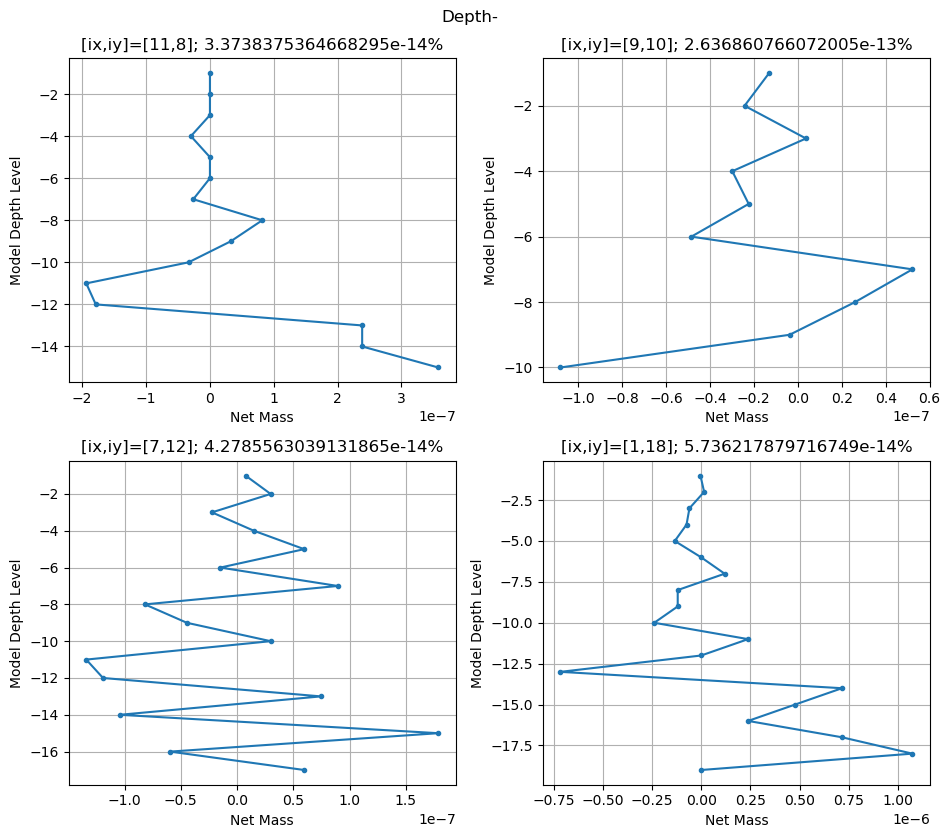

In [28]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 5):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Mass")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()

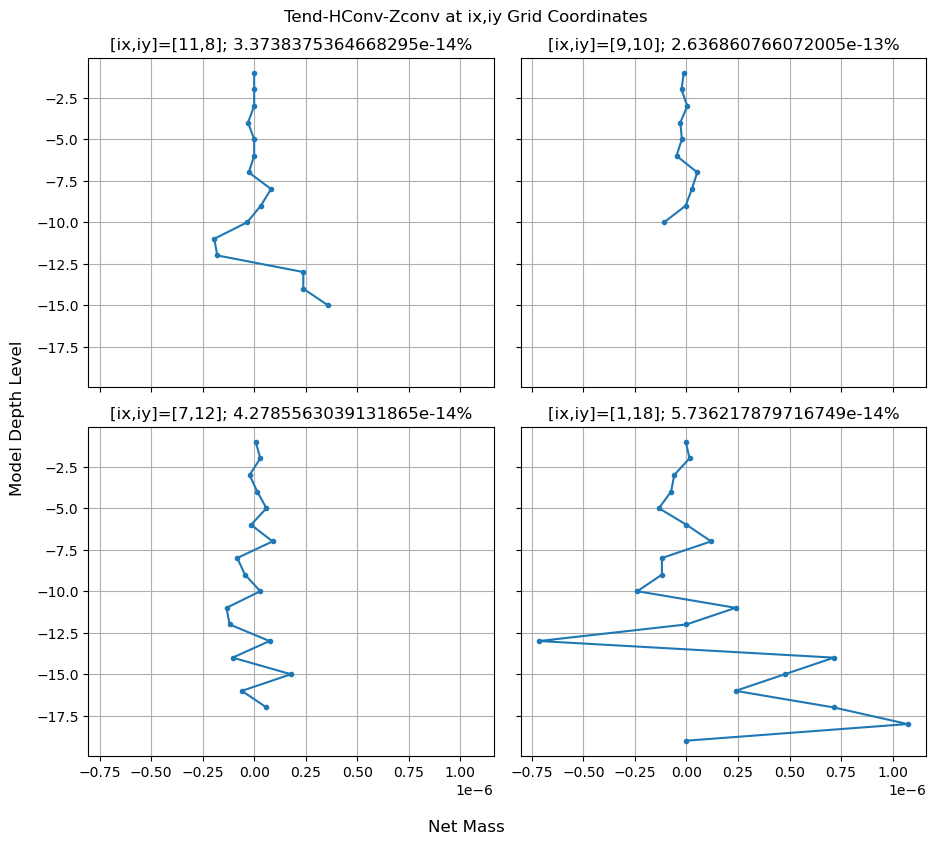

In [29]:
figpath = "/scratch2/mmurakami/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"
# Figure 1 - made better
fig,axs = plt.subplots(2,2,figsize = (9.5,8.5),sharex = True,sharey = True)
plt.suptitle("Tend-HConv-Zconv at ix,iy Grid Coordinates")
fig.supxlabel("Net Mass")
fig.supylabel("Model Depth Level")

for n, ax in enumerate(axs.flatten(),start = 1):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix]

    ax.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    ax.grid()
    ax.set_title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")

plt.tight_layout()

plt.savefig(figpath + "MassBudg_percent.png",dpi=300)
plt.show()

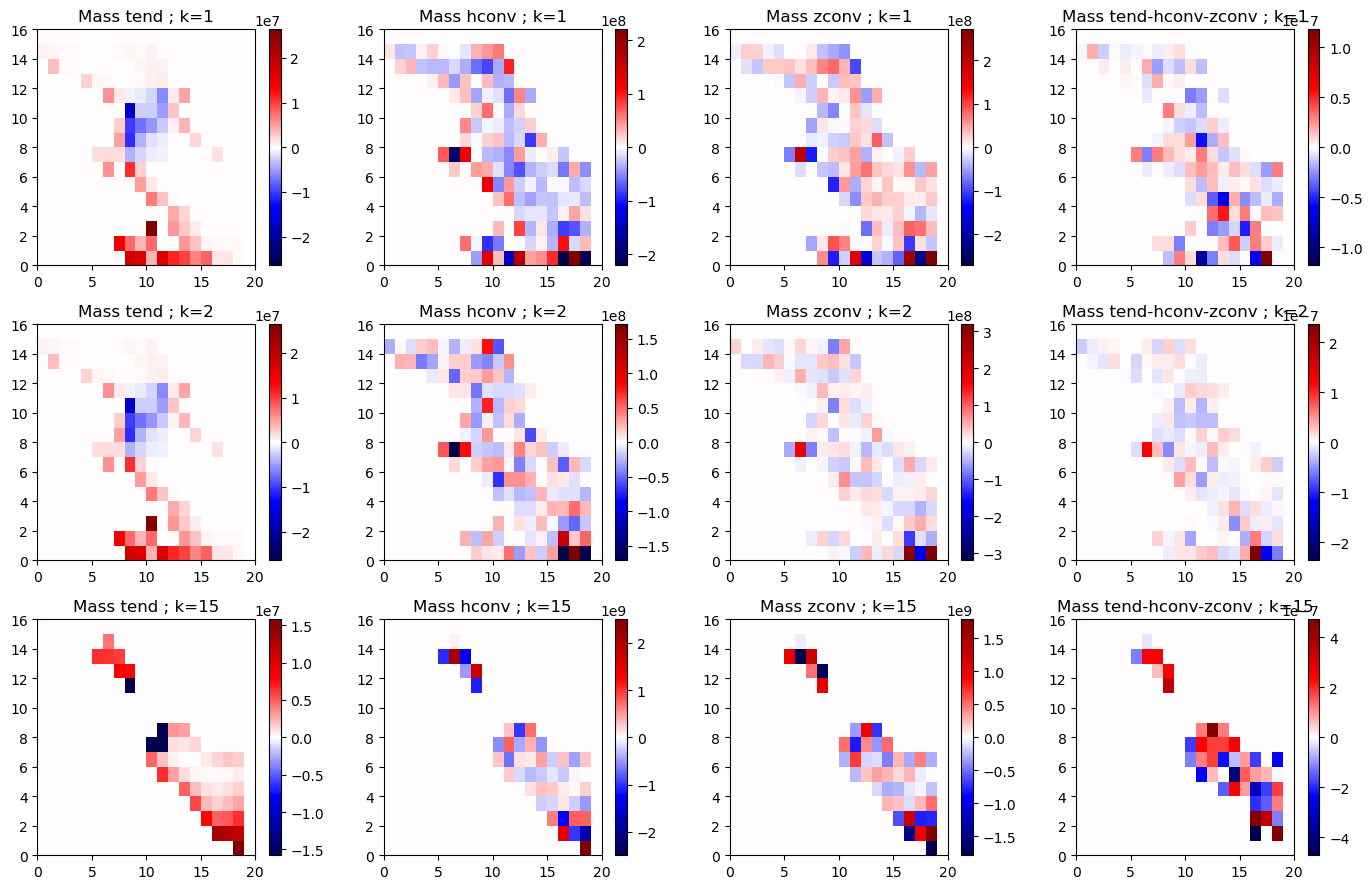

In [30]:
# Figure 2
a = budgO['fluxes']['tend'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
b = budgO['fluxes']['hconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
c = budgO['fluxes']['zconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0

klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        pcm = ax.pcolormesh(data[k1-1,:, :], cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)
        ax.set_title(f"{strbudg} {title} {str_k}")

plt.tight_layout()
# plt.savefig(f"{dirOut}{strbudg}_budget2_{t2:010}.png")
plt.show()

In [31]:
a = budgO['tend'] * hfC1p
d = budgI['tend'] * hfC1p
#b = budgO['hconv'].reshape(16,20) * hfC1p
#f = budgI['hconv'].reshape(16,20) * hfC1p

b = budgO['hconv'] * hfC1p
f = budgI['hconv'] * hfC1p
c = budgO['zconv'] * hfC1p
g = budgI['zconv'] * hfC1p

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0
d[np.isnan(d)] = 0
f[np.isnan(f)] = 0
g[np.isnan(g)] = 0

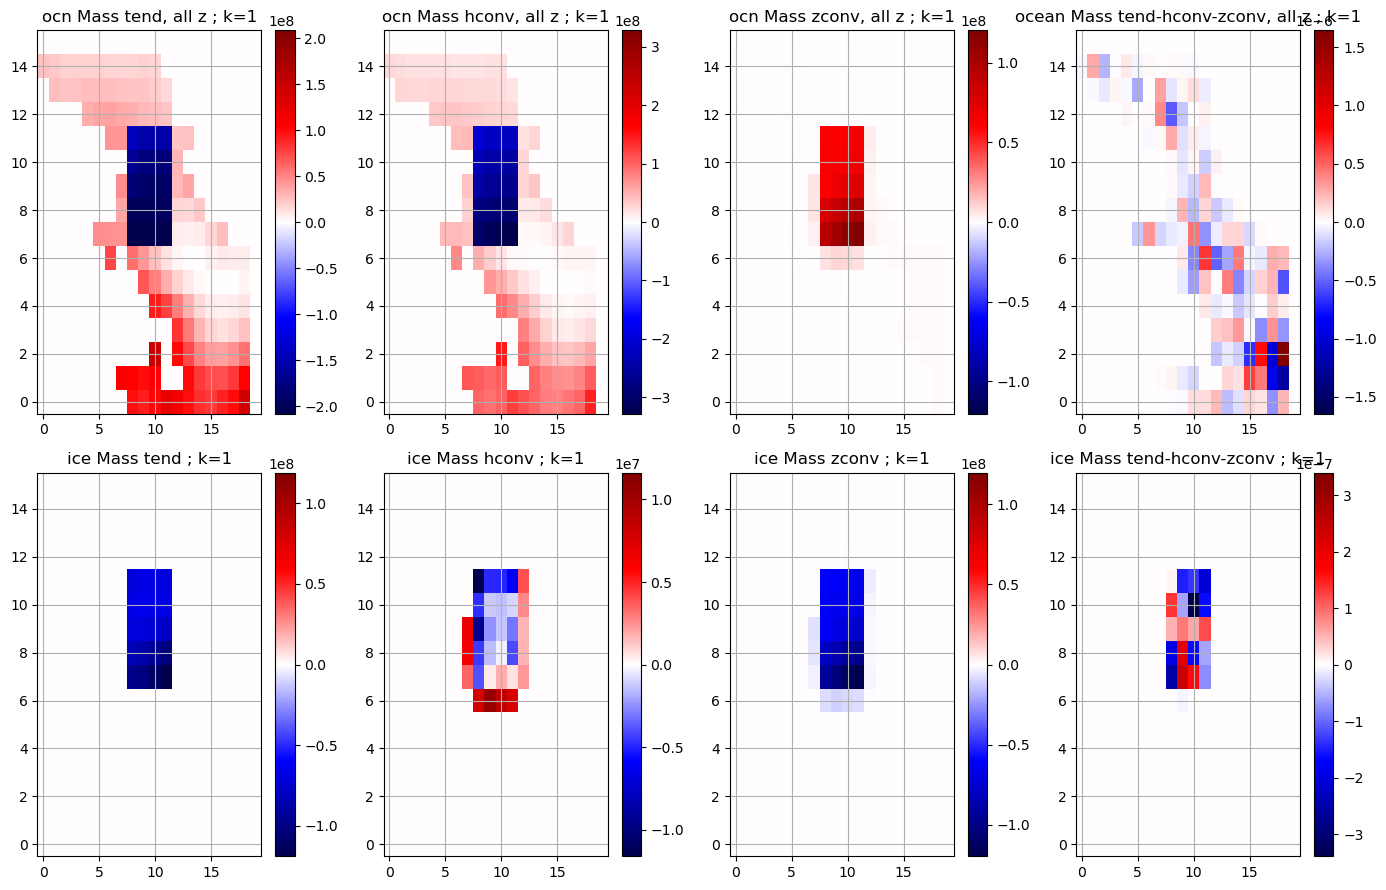

In [32]:
ix = np.arange(nx)
iy = np.arange(ny)
# 0 is the surface
k = 0

fig, axes = plt.subplots(2, 4, figsize=(14, 9))
str_k = f"; k={k+1}"

for j, (data, title_prefix, title_suffix) in enumerate([(a, 'ocn', 'tend, all z'), 
                                                        (b, 'ocn', 'hconv, all z'), 
                                                        (c, 'ocn', 'zconv, all z'),
                                                        (a-b-c, 'ocean', 'tend-hconv-zconv, all z'),
                                                        (d, 'ice', 'tend'),
                                                        (f, 'ice', 'hconv'),
                                                        (g, 'ice', 'zconv'),
                                                        (d-f-g, 'ice', 'tend-hconv-zconv')]):

    if len(data.shape) > 2:
        ax = axes[j//4, j%4]
        pcm = ax.pcolormesh(ix, iy, data[k,:,:], cmap='seismic', vmin=-0.99*np.nanmax(abs(data)), vmax=0.99*np.nanmax(abs(data)))
        fig.colorbar(pcm, ax=ax)
        ax.grid()
        ax.set_title(f"{title_prefix} {strbudg} {title_suffix} {str_k}")
    else:
        ax = axes[j//4, j%4]
        pcm = ax.pcolormesh(ix, iy, data[:,:], cmap='seismic', vmin=-0.99*np.nanmax(abs(data)), vmax=0.99*np.nanmax(abs(data)))
        fig.colorbar(pcm, ax=ax)
        ax.grid()
        ax.set_title(f"{title_prefix} {strbudg} {title_suffix} {str_k}")

plt.tight_layout()

plt.savefig(figpath + "massbudg_allz_mapped",dpi = 300)
plt.show()

## Make an example figure for presentation

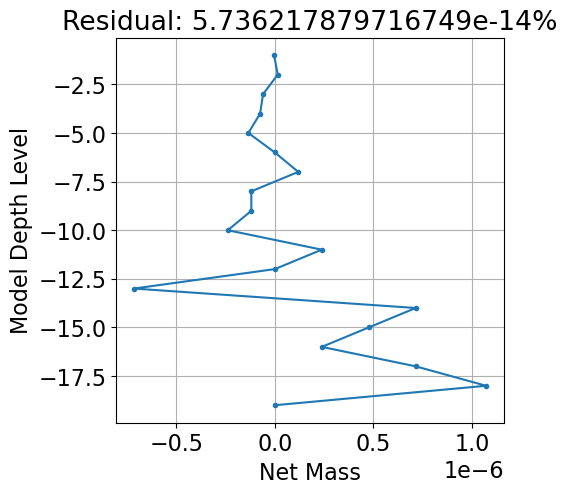

In [33]:
fig = plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 16})
#plt.title("Tend-HConv-Zconv at ix,iy Grid Coordinates")
plt.xlabel("Net Mass")
plt.ylabel("Model Depth Level")

ix,iy,k = pt[-1]
aa[:, -1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix]
plt.plot(aa[:, -1], -np.arange(1, nz+1), '.-')
plt.grid()
#plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
plt.title("Residual: " + f"{100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")

plt.savefig(figpath + "sample_massbudget_percent.png",dpi=300)
plt.show()

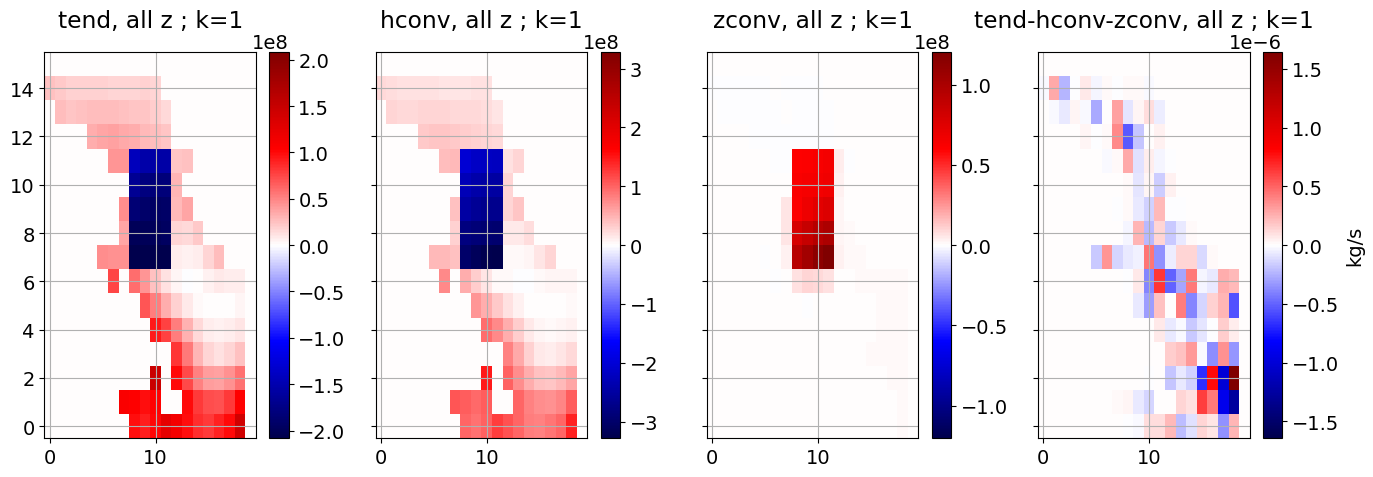

In [34]:
ix = np.arange(nx)
iy = np.arange(ny)
# 0 is the surface
k = 0
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 18  # pad is in points...


fig, axes = plt.subplots(1, 4, figsize=(14, 5),sharex = True,sharey=True)
str_k = f"; k={k+1}"

i = 0
for j, (data, title_prefix, title_suffix) in enumerate([(a, 'ocn', 'tend, all z'), 
                                                        (b, 'ocn', 'hconv, all z'), 
                                                        (c, 'ocn', 'zconv, all z'),
                                                        (a-b-c, 'ocean', 'tend-hconv-zconv, all z')]):

    if len(data.shape) > 2:
        ax = axes[j%4]
        pcm = ax.pcolormesh(ix, iy, data[k,:,:], cmap='seismic', vmin=-0.99*np.nanmax(abs(data)), vmax=0.99*np.nanmax(abs(data)))
        ax.grid()
        ax.set_title(f"{title_suffix} {str_k}")
        if i == 3:
            fig.colorbar(pcm, ax=ax,label="kg/s")
        else:
            fig.colorbar(pcm, ax=ax)
    else:
        ax = axes[j%4]
        pcm = ax.pcolormesh(ix, iy, data[:,:], cmap='seismic', vmin=-0.99*np.nanmax(abs(data)), vmax=0.99*np.nanmax(abs(data)))
        fig.colorbar(pcm, ax=ax)
        ax.grid()
        ax.set_title(f"{title_suffix} {str_k}")
    i += 1

plt.tight_layout()

#plt.suptitle("Ocean Mass Convergences")
plt.savefig(figpath + "massbudg_allz_mapped",dpi = 300)
plt.show()

In [35]:
figpath

'/scratch2/mmurakami/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/'